Epoch 1, Generator Loss: 0.8401, Discriminator Loss: 1.0842
Epoch 2, Generator Loss: 1.4786, Discriminator Loss: 0.8917
Epoch 3, Generator Loss: 0.7721, Discriminator Loss: 1.7455
Epoch 4, Generator Loss: 1.2498, Discriminator Loss: 1.0110
Epoch 5, Generator Loss: 1.4629, Discriminator Loss: 0.8758
Epoch 6, Generator Loss: 0.6305, Discriminator Loss: 1.7013
Epoch 7, Generator Loss: 1.1227, Discriminator Loss: 1.0354
Epoch 8, Generator Loss: 1.2524, Discriminator Loss: 0.8801


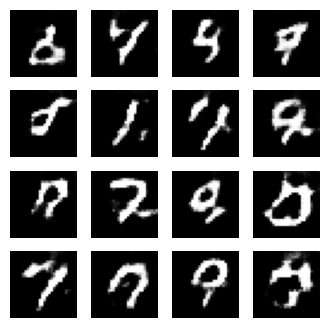

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
def load_data():
  (x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5) / 127.5 #Normalize to (-1 to 1)
  x_train = np.expand_dims(x_train, axis=-1) # Add chanel dimension
  return tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128).prefetch(tf.data.AUTOTUNE)

def build_generator():
  model = tf.keras.Sequential([
      layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Reshape((7, 7, 256)), # before i used dense, dense provides op as 1D while applying to conv2D i need to reshape it
      layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.ReLU(),
      layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
  ])
  return model


def build_discriminator():
  model = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
      layers.LeakyReLU(alpha=0.2),
      layers.Dropout(0.3),
      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(alpha=0.2),
      layers.Dropout(0.3),
      layers.Flatten(),
      layers.Dense(1, activation='sigmoid')
  ])
  return model

def get_optimizers():
  return tf.keras.optimizers.Adam(1e-4), tf.keras.optimizers.Adam(1e-4)

generator = build_generator()
discriminator = build_discriminator()
g_opt, d_opt = get_optimizers()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits= False)

# Discriminator wants real image as 1 and fake image as 0
# Generator wants fake image to be classified as 1 that is real images

@tf.function # @tf.function → compiles this Python function into a fast TensorFlow graph for GPU execution.
def train_step(images):
  noise = tf.random.normal([128, 100]) # creates a batch of 128 random noise vectors, each of size 100 dimensional

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # Generator takes the random noise as input and produces fake images

      real_output = discriminator(images, training=True) # discriminator predicts whether real MNIST images are real (should be close to 1)
      fake_output = discriminator(generated_images, training=True) # discriminator predicts whether fake images are real (should be close to 0)

      gen_loss = loss_fn(tf.ones_like(fake_output), fake_output) #tf.ones_like(fake_op) creates a tensor of ones, representing "real" labels
                                                            # loss_fn (Binary cross entropy loss) measures how close fake_op is to 1
                                                            # lower generator loss means the generator is successfully fooling the discriminator
                                                            # higher generator loss means the generator is performing poorly
      disc_loss = (loss_fn(tf.ones_like(real_output), real_output) + # how well discriminator classifies real images as real (close to 1)
                 loss_fn(tf.zeros_like(fake_output), fake_output)) # how well discriminator classifies fake images as fake (close to 0)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # compute gradients for generator parameter #tf.GradientTape() is like a camera that records all the math operations happening inside it.
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # compute gradients for discriminator params

  g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # update generator's weight
  d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # update discriminator's weight

  return gen_loss, disc_loss

def train(dataset, epochs=20):
  for epoch in range(epochs):
    for batch in dataset:
      gen_loss, disc_loss = train_step(batch)
    print(f"Epoch {epoch+1}, Generator Loss: {gen_loss.numpy():.4f}, Discriminator Loss: {disc_loss.numpy():.4f}")

def generate_and_show():
  noise = tf.random.normal([16, 100])
  images= generator(noise, training=False)
  images= (images + 1) / 2
  fig, axes = plt.subplots(4, 4, figsize=(4, 4))
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i, :, :, 0], cmap='gray')
    ax.axis('off')
  plt.show()

# Load data and train
mnist_data = load_data()
train(mnist_data, epochs=8)
generate_and_show()